In [142]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc
import numpy as np
from glob import glob
from skimage.io import imread
from livelossplot import PlotLossesKerasTF
from functools import *
os.environ["CUDA_VISIBLE_DEVICES"]='0'
import random
BASE_IMG_PATH=os.path.join('hecktor-master','data','hecktor_test','resampled')
PRED_PATH=os.path.join('hecktor-master','data','hecktor_test','predicted')
MODEL_PATH='weights'

model_name = 'multi_deepsuper_dense_BN_augment_window_dropout01'
BATCH_SIZE = 3
INPUT_SHAPE = (144,144,144,2)
PROJECT_NAME = 'hector_test'




In [143]:
glob(os.path.join(BASE_IMG_PATH,'*'))


['hecktor-master/data/hecktor_test/resampled/CHUV038_pt.nii.gz',
 'hecktor-master/data/hecktor_test/resampled/CHUV045_pt.nii.gz',
 'hecktor-master/data/hecktor_test/resampled/CHUV031_pt.nii.gz',
 'hecktor-master/data/hecktor_test/resampled/CHUV007_pt.nii.gz',
 'hecktor-master/data/hecktor_test/resampled/CHUV024_ct.nii.gz',
 'hecktor-master/data/hecktor_test/resampled/CHUV053_pt.nii.gz',
 'hecktor-master/data/hecktor_test/resampled/CHUV047_pt.nii.gz',
 'hecktor-master/data/hecktor_test/resampled/CHUV035_pt.nii.gz',
 'hecktor-master/data/hecktor_test/resampled/CHUV045_ct.nii.gz',
 'hecktor-master/data/hecktor_test/resampled/CHUV011_pt.nii.gz',
 'hecktor-master/data/hecktor_test/resampled/CHUV002_pt.nii.gz',
 'hecktor-master/data/hecktor_test/resampled/CHUV026_pt.nii.gz',
 'hecktor-master/data/hecktor_test/resampled/CHUV020_ct.nii.gz',
 'hecktor-master/data/hecktor_test/resampled/CHUV038_ct.nii.gz',
 'hecktor-master/data/hecktor_test/resampled/CHUV030_ct.nii.gz',
 'hecktor-master/data/hec

hecktor-master/data/hecktor_test/predicted
hecktor-master/data/hecktor_test/predicted/CHUV024.nii.gz
hecktor-master/data/hecktor_test/predicted/CHUV045.nii.gz
hecktor-master/data/hecktor_test/predicted/CHUV020.nii.gz
hecktor-master/data/hecktor_test/predicted/CHUV038.nii.gz
hecktor-master/data/hecktor_test/predicted/CHUV030.nii.gz
53  matching files found: hecktor-master/data/hecktor_test/resampled/CHUV045_ct.nii.gz hecktor-master/data/hecktor_test/resampled/CHUV045_pt.nii.gz
0.22546052932739258


Text(0.5, 1.0, 'PT')

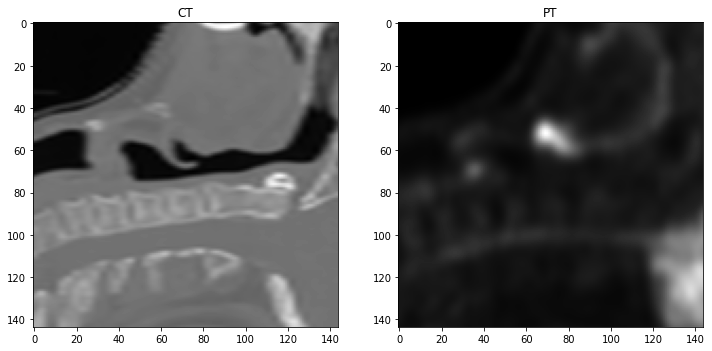

In [144]:
# show some of the files
all_ct_images= glob(os.path.join(BASE_IMG_PATH,'*ct.nii.gz'))
all_pt_images = [x.replace('ct.nii.gz', 'pt.nii.gz') for x in all_ct_images]

##create prediciton paths
all_pred_path = [x.replace(BASE_IMG_PATH,PRED_PATH) for x in all_ct_images]
all_pred_path = [x.replace('_ct','') for x in all_pred_path]

print(PRED_PATH)
for i in range(5):
    print(all_pred_path[i])


rand_index = np.random.randint(0, len(all_ct_images))

print(len(all_ct_images),' matching files found:',all_ct_images[rand_index], all_pt_images[rand_index])

%matplotlib inline
try:
    import nibabel as nib
except:
    raise ImportError('Install NIBABEL')
    
import time

start = time.time()
test_ct=np.asarray(nib.load(all_ct_images[rand_index]).dataobj)
test_pt=np.asarray(nib.load(all_pt_images[rand_index]).dataobj)

import random

print(time.time() - start )
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))

ax1.imshow(test_ct[test_ct.shape[0]//2], cmap = 'gray')
ax1.set_title('CT')
ax2.imshow(test_pt[test_pt.shape[0]//2], cmap = 'gray')
ax2.set_title('PT')


In [145]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, add, multiply
from tensorflow.keras.optimizers import Adam, SGD


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MaxPooling3D
from tensorflow.keras.layers import Conv3D, Conv3DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection +K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def categorical_focal_loss_fixed(logits, labels, gamma=2., alpha=.25):
    """
    :param logits: A tensor resulting from a softmax
    :param labels: A tensor of the same shape as `logits`
    :input shape: [batch, depth, hight, width, channels]
    :return: Output tensor.
    """

    # Scale predictions so that the class probas of each sample sum to 1
    logits /= K.sum(logits, axis=-1, keepdims=True)

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    logits = K.clip(logits, epsilon, 1. - epsilon)

    # Calculate Cross Entropy
    cross_entropy = -labels * K.log(logits)

    # Calculate Focal Loss
    loss = alpha * K.pow(1 - logits, gamma) * cross_entropy

    # Sum the losses in mini_batch
#    return K.sum(loss, axis=1)
    return  K.mean(loss)


def hyper_loss(y_true, y_pred):
    return  dice_coef_loss(y_true, y_pred) + categorical_focal_loss_fixed(y_true, y_pred)



def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

def lovaz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(y_true, 'int32'), K.cast(y_pred, 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    
    logits = y_pred 
    loss = lovasz_hinge(logits, y_true, per_image = False, ignore = None)
    return loss
def dice_lovaz(y_true, y_pred):
    return 0.5*lovaz_loss(y_true, y_pred) + dice_coef_loss(y_true, y_pred)


def make144(image):
    new_image = image[:144,:144,:144]
    #new_image = skimage.transform.resize(image, (144,144,144), mode= 'edge')
    return new_image

def preprocess(image):
    if image.shape != (144,144,144):
        image = make144(image)
    new_image = (image - image.mean())/image.std()
    
    return new_image

In [146]:
os.environ["CUDA_VISIBLE_DEVICES"]='1'
model = tf.keras.models.load_model(os.path.join(MODEL_PATH, model_name+'.h5'), 
                                           custom_objects={'hyper_loss':hyper_loss,
                                                           'dice_coef': dice_coef,
                                                           'lovaz_loss': lovaz_loss,
                                                           'dice_lovaz':dice_lovaz, 
                                                           'bce_dice_loss':bce_dice_loss,
                                                           'dice_coef_loss': dice_coef_loss})

In [147]:

def touch_folder(model_dir):
    """
    This function returns the absolute path of `model_dir` if exists
    otherwise try to create the folder and returns the absolute path.
    """
    model_dir = os.path.expanduser(model_dir)
    if not os.path.exists(model_dir):
        try:
            os.makedirs(model_dir)
        except (OSError, TypeError):
            print('could not create model folder: %s', model_dir)
            raise
    absolute_dir = os.path.abspath(model_dir)
    # tf.logging.info('accessing output folder: {}'.format(absolute_dir))
    return absolute_dir

def save_volume_nd(img_data, save_path, affine=np.eye(4)):
    """
    Save the img_data to nifti image, if the final dimensions of the 5D array
    are 1's, save the lower dimensional image to disk by squeezing the trailing
    single dimensional spaces away.

    :param img_data: 5d img to save
    :param filename: filename under which to save the img_data
    :param save_path:
    :param affine: an affine matrix.
    :return:
    """
    if img_data is None:
        return
    # 5D images are not well supported by many image processing tools
    # (or are assumed to be time series)
    # Squeeze 5d processing space into smaller image spatial size (3d or 2d)
    # for improved compatibility with
    # external visualization/processing tools like Slicer3D, ITK,
    # SimpleITK, etc ...
    sqeezed_shape = img_data.shape
    while sqeezed_shape[0] == 1:
        sqeezed_shape = sqeezed_shape[1:]
        
    while sqeezed_shape[-1] == 1:
        sqeezed_shape = sqeezed_shape[0:-1]
    img_data.shape = sqeezed_shape
    
    img_nii = nib.Nifti1Image(img_data, affine)
    # img_nii.set_data_dtype(np.dtype(np.float32))
    output_name = save_path
    try:
        if os.path.isfile(output_name):
            print('File %s exists, overwriting the file.',
                               output_name)
        nib.save(img_nii, output_name)
    except OSError:
        print("writing failed {}".format(output_name))
        raise
    print('Saved {}'.format(output_name))

In [148]:
all_ct_images[0][-17:-10]
all_pt_images[0][-17:-10]

'CHUV024'

In [149]:
import numpy as np
import SimpleITK as sitk


def get_sitk_volume_from_np(np_image, pixel_spacing, image_position_patient):
    trans = (2, 1, 0)
    sitk_image = sitk.GetImageFromArray(np.transpose(np_image, trans))
    sitk_image.SetSpacing(pixel_spacing)
    sitk_image.SetOrigin(image_position_patient)
    return sitk_image

def to_sitk_image(array):
    """
    Convert a numpy array to a SimpleITK image.
    """
    return sitk.GetImageFromArray(array)

    
def to_np_array(image):
    """
    Convert a SimpleITK image to a numpy array.
    """
    return sitk.GetArrayFromImage(image)


def load_nii(path):
    """
    Load a .nii(.gz) file as a numpy array.
    """
    return to_np_array(sitk.ReadImage(path))



In [150]:
path_to_bbox_file = '/home/sysgen/gitlab/HNSCC-ct-pet-GTV/hecktor-master/data/hecktor_test/bbox_test.csv'

In [151]:
origin_path = '/home/sysgen/gitlab/HNSCC-ct-pet-GTV/hecktor-master/data/hecktor_test/hecktor_nii_test'

In [152]:
file_chunk = all_pred_path
from skimage.morphology import square, opening

import numpy as np
cube = []
for i in range(3):
    cube.append(square(3))
cube = np.asarray(cube)
    
#all_pred_path[:1]


bb_df = pd.read_csv(path_to_bbox_file, index_col='PatientID')  # with path_to_bbox_file the file to bbox_test.csv and with pandas imported as pd

pred = []
for file in range(len(file_chunk)):   
   
    patient_id = file_chunk[file][-14:-7]
    
    
    print(all_ct_images[file],all_pt_images[file], all_pred_path[file])
    
    ct_id = all_ct_images[file][-17:-10]
    pt_id = all_ct_images[file][-17:-10]
    pred_id = all_pred_path[file][-14:-7]
    
    if ct_id != pt_id or ct_id !=  pred_id:
        raise ValueError
    
    
    _ct=load_nii(all_ct_images[file])
    _pt=load_nii(all_pt_images[file])
    

    _ct[_ct<-150] = -150
    _ct[_ct>150] = 150
    _ct = preprocess(_ct)
    _pt = preprocess(_pt)
    x = np.concatenate((_ct[..., np.newaxis], _pt[..., np.newaxis]), -1)
    x = x[np.newaxis, ...]
    
    
    baseimg = sitk.ReadImage(all_ct_images[file])
    #baseimg1 = sitk.ReadImage(os.path.join(origin_path,patient_id,all_ct_images[file][-17:]))
    
    origin = baseimg1.GetOrigin()
    img = model.predict(x)
    img.shape = (144,144,144)
    img[img>0.5] = 1
    img[img<=0.5] = 0
    #img = opening(img, cube)
    
    #trans = (2, 1, 0)
    sitk_image = sitk.GetImageFromArray(img)
    #sitk_image.CopyInformation(baseimg)
    
    sitk_image.SetSpacing((1.0, 1.0, 1.0)) # You can change this value to the one you used
    sitk_image.SetOrigin((bb_df.loc[[patient_id], ['x1','y1','z1']].values.tolist()[0])) # with the patient_id = 'CHUV001' for instance
    #sitk_image.SetOrigin(origin)
    #print(origin,(bb_df.loc[[patient_id], ['x1','y1','z1']].values))
    sitk.WriteImage(sitk_image, all_pred_path[file])  
    
    #pred.append(img)
    
    #save_volume_nd(img, all_pred_path[file])
    
    

hecktor-master/data/hecktor_test/resampled/CHUV024_ct.nii.gz hecktor-master/data/hecktor_test/resampled/CHUV024_pt.nii.gz hecktor-master/data/hecktor_test/predicted/CHUV024.nii.gz
hecktor-master/data/hecktor_test/resampled/CHUV045_ct.nii.gz hecktor-master/data/hecktor_test/resampled/CHUV045_pt.nii.gz hecktor-master/data/hecktor_test/predicted/CHUV045.nii.gz
hecktor-master/data/hecktor_test/resampled/CHUV020_ct.nii.gz hecktor-master/data/hecktor_test/resampled/CHUV020_pt.nii.gz hecktor-master/data/hecktor_test/predicted/CHUV020.nii.gz
hecktor-master/data/hecktor_test/resampled/CHUV038_ct.nii.gz hecktor-master/data/hecktor_test/resampled/CHUV038_pt.nii.gz hecktor-master/data/hecktor_test/predicted/CHUV038.nii.gz
hecktor-master/data/hecktor_test/resampled/CHUV030_ct.nii.gz hecktor-master/data/hecktor_test/resampled/CHUV030_pt.nii.gz hecktor-master/data/hecktor_test/predicted/CHUV030.nii.gz
hecktor-master/data/hecktor_test/resampled/CHUV019_ct.nii.gz hecktor-master/data/hecktor_test/resamp

hecktor-master/data/hecktor_test/resampled/CHUV022_ct.nii.gz hecktor-master/data/hecktor_test/resampled/CHUV022_pt.nii.gz hecktor-master/data/hecktor_test/predicted/CHUV022.nii.gz
hecktor-master/data/hecktor_test/resampled/CHUV048_ct.nii.gz hecktor-master/data/hecktor_test/resampled/CHUV048_pt.nii.gz hecktor-master/data/hecktor_test/predicted/CHUV048.nii.gz
hecktor-master/data/hecktor_test/resampled/CHUV008_ct.nii.gz hecktor-master/data/hecktor_test/resampled/CHUV008_pt.nii.gz hecktor-master/data/hecktor_test/predicted/CHUV008.nii.gz
hecktor-master/data/hecktor_test/resampled/CHUV031_ct.nii.gz hecktor-master/data/hecktor_test/resampled/CHUV031_pt.nii.gz hecktor-master/data/hecktor_test/predicted/CHUV031.nii.gz
hecktor-master/data/hecktor_test/resampled/CHUV005_ct.nii.gz hecktor-master/data/hecktor_test/resampled/CHUV005_pt.nii.gz hecktor-master/data/hecktor_test/predicted/CHUV005.nii.gz
hecktor-master/data/hecktor_test/resampled/CHUV035_ct.nii.gz hecktor-master/data/hecktor_test/resamp

In [58]:
sitk_image.GetOrigin()

(-72.4609375, -102.5390625, 79.50001907348633)

In [53]:
(bb_df.loc[[patient_id], ['x1','y1','z1']].values.tolist()[0])

[-75.1953125, -121.6796875, 79.84490966796875]

In [55]:
plt.imshow(img[index])

NameError: name 'index' is not defined

In [10]:
pred = np.asarray(pred)
np.save('pred', pred)


In [15]:
from skimage.morphology import square, opening

import numpy as np
cube = []
for i in range(3):
    cube.append(square(3))
cube =np.asarray(cube)
cube.shape
img = pred[2]

img[img>0.5] = 1
img[img<=0.5] = 0
img.shape = (144,144,144)
image = opening(img, cube)


index = 60
plt.imshow(img[index])
plt.show()
plt.imshow(image[index])
plt.show()

IndexError: list index out of range

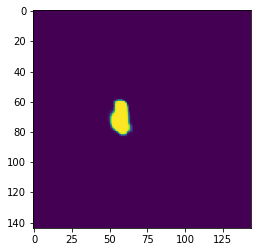

In [103]:
save_volume_nd(pred[0], all_pred_path[0])

Saved hecktor-master\data\hecktor_test\predicted\CHUV001.nii.gz


In [34]:
print(pred.shape)

pred[pred>0.5] = 1
pred[pred<=0.5] = 0


for index in range(pred.shape[0]):
    save_volume_nd(pred[index], all_pred_path[index])
    

(53, 1, 144, 144, 144, 1)
File %s exists, overwriting the file. hecktor-master\data\hecktor_test\predicted\CHUV001.nii.gz
Saved hecktor-master\data\hecktor_test\predicted\CHUV001.nii.gz
File %s exists, overwriting the file. hecktor-master\data\hecktor_test\predicted\CHUV002.nii.gz
Saved hecktor-master\data\hecktor_test\predicted\CHUV002.nii.gz
File %s exists, overwriting the file. hecktor-master\data\hecktor_test\predicted\CHUV003.nii.gz
Saved hecktor-master\data\hecktor_test\predicted\CHUV003.nii.gz
File %s exists, overwriting the file. hecktor-master\data\hecktor_test\predicted\CHUV004.nii.gz
Saved hecktor-master\data\hecktor_test\predicted\CHUV004.nii.gz
File %s exists, overwriting the file. hecktor-master\data\hecktor_test\predicted\CHUV005.nii.gz
Saved hecktor-master\data\hecktor_test\predicted\CHUV005.nii.gz
File %s exists, overwriting the file. hecktor-master\data\hecktor_test\predicted\CHUV006.nii.gz
Saved hecktor-master\data\hecktor_test\predicted\CHUV006.nii.gz
File %s exists

In [8]:

def touch_folder(model_dir):
    """
    This function returns the absolute path of `model_dir` if exists
    otherwise try to create the folder and returns the absolute path.
    """
    model_dir = os.path.expanduser(model_dir)
    if not os.path.exists(model_dir):
        try:
            os.makedirs(model_dir)
        except (OSError, TypeError):
            print('could not create model folder: %s', model_dir)
            raise
    absolute_dir = os.path.abspath(model_dir)
    # tf.logging.info('accessing output folder: {}'.format(absolute_dir))
    return absolute_dir

def save_volume_nd(img_data, save_path, affine=np.eye(4)):
    """
    Save the img_data to nifti image, if the final dimensions of the 5D array
    are 1's, save the lower dimensional image to disk by squeezing the trailing
    single dimensional spaces away.

    :param img_data: 5d img to save
    :param filename: filename under which to save the img_data
    :param save_path:
    :param affine: an affine matrix.
    :return:
    """
    if img_data is None:
        return
    # 5D images are not well supported by many image processing tools
    # (or are assumed to be time series)
    # Squeeze 5d processing space into smaller image spatial size (3d or 2d)
    # for improved compatibility with
    # external visualization/processing tools like Slicer3D, ITK,
    # SimpleITK, etc ...
    sqeezed_shape = img_data.shape
    while sqeezed_shape[0] == 1:
        sqeezed_shape = sqeezed_shape[1:]
        
    while sqeezed_shape[-1] == 1:
        sqeezed_shape = sqeezed_shape[0:-1]
    img_data.shape = sqeezed_shape
    
    img_nii = nib.Nifti1Image(img_data, affine)
    # img_nii.set_data_dtype(np.dtype(np.float32))
    output_name = save_path
    try:
        if os.path.isfile(output_name):
            print('File %s exists, overwriting the file.',
                               output_name)
        nib.save(img_nii, output_name)
    except OSError:
        print("writing failed {}".format(output_name))
        raise
    print('Saved {}'.format(output_name))